In [1]:
import numpy as np
import pandas as pd
from itertools import combinations

from datetime import datetime, timedelta
from tqdm.notebook import tqdm
tqdm.pandas()

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold, RepeatedStratifiedKFold, GroupKFold

import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgbm
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve, select_threshold

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 250
pd.options.display.max_columns = 250

### 1. Pipeline Ayarları

In [2]:
class CFG:
    MAIN_PATH = '/kaggle/input/anadolu-hayat-emeklilik-datathon-2024'
    LOCAL_PATH = '/kaggle/input/ahe-2024-model-externaldata'
    WEIGHT = [0.0385,0.0328,0.2791,0.1812,0.0113,0.2952,0.1614,0.0001]
    PRODUCT = ['HU06','HU07','HU11','HU12','HU14','HU15','HU19','UA']
    TARGET_DICT = dict(zip(PRODUCT, np.arange(len(PRODUCT))))
    INV_TARGET_DICT = {v: k for k, v in TARGET_DICT.items()}
    TRAIN = False
    USE_USD = False

### 2. Ham Verinin Okunması

In [3]:
train_df = pd.read_csv(f'{CFG.MAIN_PATH}/train.csv')
test_df = pd.read_csv(f'{CFG.MAIN_PATH}/test.csv')
ss = pd.read_csv(f'{CFG.MAIN_PATH}/sample_submission.csv')

urun_ozellik_df = pd.read_excel(f'{CFG.MAIN_PATH}/Urun Ozellikleri.xlsx').rename(columns={
    "Ürün ": "InsuranceType",
    "Sigortas Süresi ": "InsuranceTime",
    "Yenileme Fonksiyonu ": "InsuranceRenewFunc",
    "Yaş Gereksinimi": "InsuranceAgeReq",
    "Biriktiren/ Koruma": "InsuranceSaveType",
    "Taşınan Teminat": "InsuranceGuarantee",
    "Kredili/Kredisiz": "InsuranceHasCredit",
    "Grup/Ferdi": "InsuranceGroupType",
    }).drop(columns=["Branş "]).fillna("UNKNOWN")

### 3. Üçüncü Parti Veri

#### Şehirler
Modelin müşteri şehrinin enlem-boylam konum bilgisinden bir şey öğrenmesi mümkün olabilir.

**Kaynak:** https://gist.github.com/ozdemirburak/4821a26db048cc0972c1beee48a408de

In [4]:
city_df = pd.read_json(f'{CFG.LOCAL_PATH}/cities_en.json').rename(columns={"plate": "IL"})

#### Dolar Kuru
Müşterinin gelirlerini beyan ettiği döneme ait kurdan faydalanılarak gelirlerin dönemine göre USD karşılığı alınabilir.

**Kaynak:** https://evds2.tcmb.gov.tr/index.php?/evds/serieMarket/#collapse_2

In [5]:
usd_df = pd.read_excel(f'{CFG.LOCAL_PATH}/dolar.xlsx')
usd_df['date'] = pd.to_datetime(usd_df['date'])

### 4. Verilerin Birleştirilmesi ve Önişlenmesi

In [6]:
train_df['data'] = 'train'
test_df['data'] = 'test'

all_df = pd.concat([train_df,test_df],axis=0).reset_index(drop=True)

rg_cols = [col for col in all_df.columns if "_RG" in col]

### 5. EDA

#### Numerik ve çok değere sahip olan featureların dağılımı
Değerlerin train ve test arasında çoğu zaman uyumlu dağıldığını görebiliyoruz. Fakat bazı featurelar için train datasının daha yüksek değerlerde biriktiğini söyleyebiliriz.

0it [00:00, ?it/s]

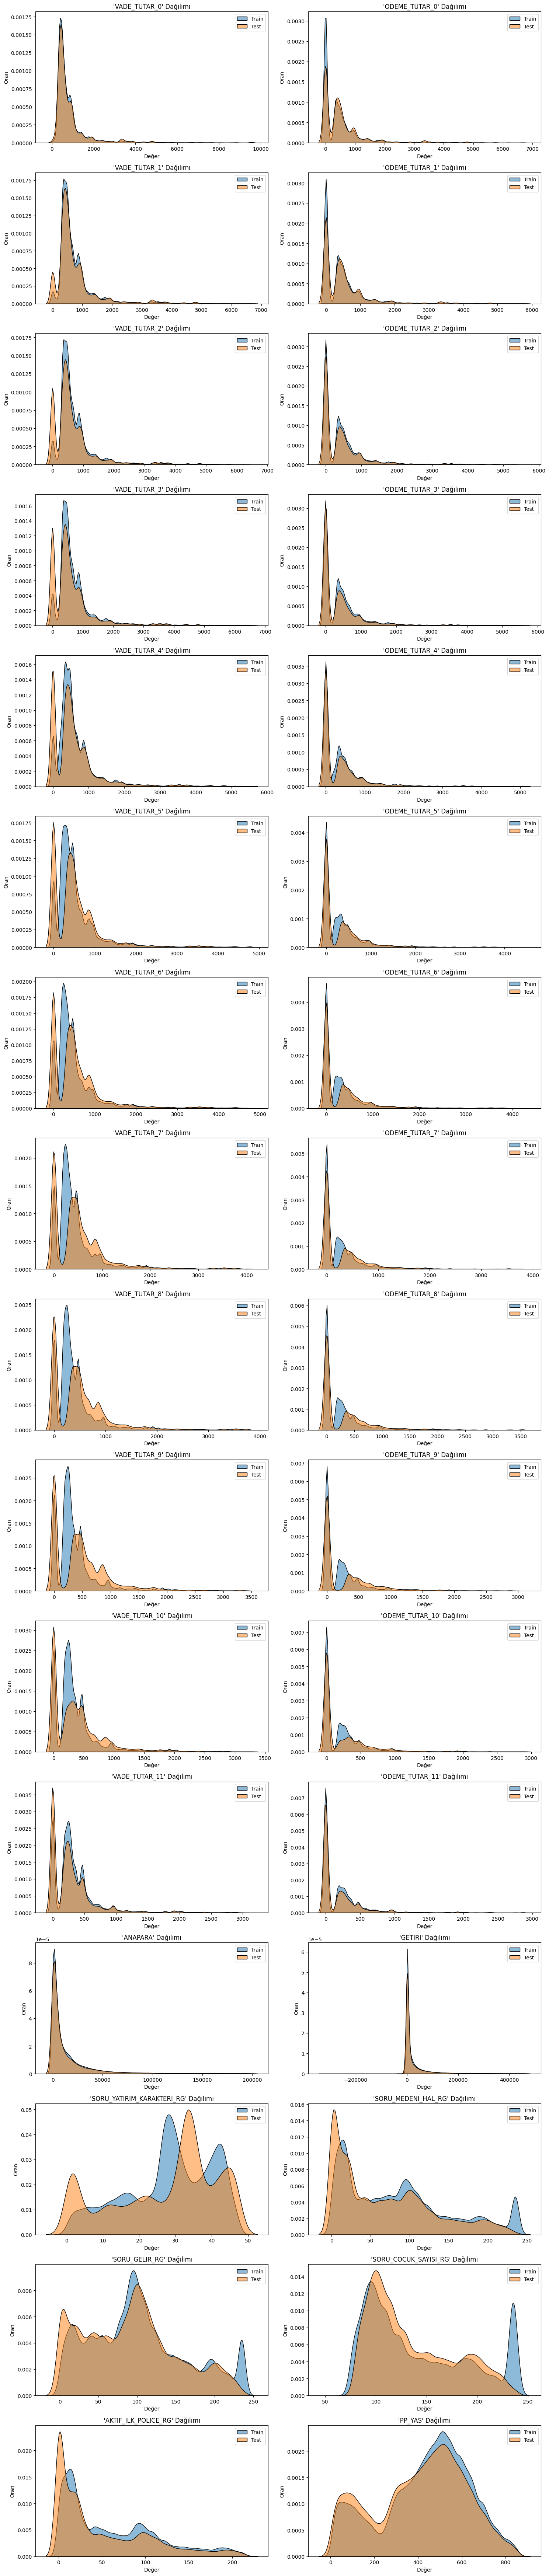

In [7]:
feat_cols=[
    'VADE_TUTAR_0','ODEME_TUTAR_0', 'VADE_TUTAR_1', 'ODEME_TUTAR_1', 'VADE_TUTAR_2',
    'ODEME_TUTAR_2', 'VADE_TUTAR_3', 'ODEME_TUTAR_3', 'VADE_TUTAR_4',
    'ODEME_TUTAR_4', 'VADE_TUTAR_5', 'ODEME_TUTAR_5', 'VADE_TUTAR_6',
    'ODEME_TUTAR_6', 'VADE_TUTAR_7', 'ODEME_TUTAR_7', 'VADE_TUTAR_8',
    'ODEME_TUTAR_8', 'VADE_TUTAR_9', 'ODEME_TUTAR_9', 'VADE_TUTAR_10',
    'ODEME_TUTAR_10', 'VADE_TUTAR_11', 'ODEME_TUTAR_11', 'ANAPARA', 'GETIRI',
    'SORU_YATIRIM_KARAKTERI_RG', 'SORU_MEDENI_HAL_RG', 'SORU_GELIR_RG',
    'SORU_COCUK_SAYISI_RG', 'AKTIF_ILK_POLICE_RG', 'PP_YAS'
]

fig, axes = plt.subplots(nrows = int(np.round(len(feat_cols)/2 + 0.01)),
                         ncols = 2)
axes = axes.flatten()
fig.set_size_inches(15, 70)

for ax, col in tqdm(zip(axes, feat_cols)):

    higher_q = train_df[col].quantile(0.99)
    
    sns.kdeplot(data=train_df[train_df[col]<=higher_q][col],
                ax=ax,
                label="Train",
                alpha=0.5,
                multiple="stack")
    
    sns.kdeplot(data=test_df[test_df[col]<=higher_q][col],
                ax=ax,
                label="Test",
                alpha=0.5,
                multiple="stack")
    
    ax.set_title(f"'{col}' Dağılımı")
    ax.set_xlabel("Değer")
    ax.set_ylabel("Oran")
    ax.legend()
    
plt.tight_layout()
plt.show()

#### Kategorik değerlerin dağılımı

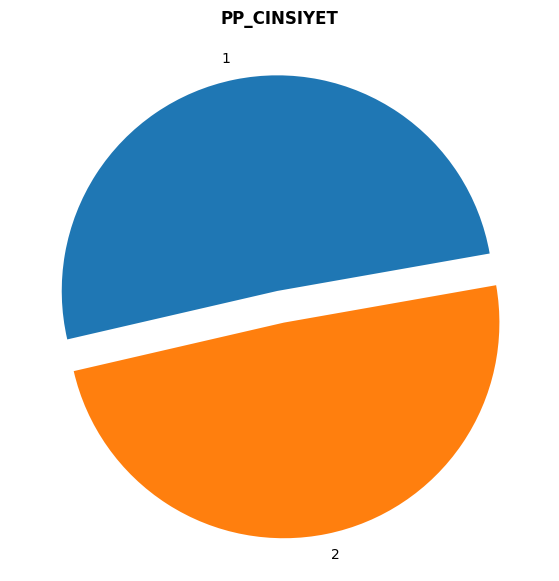

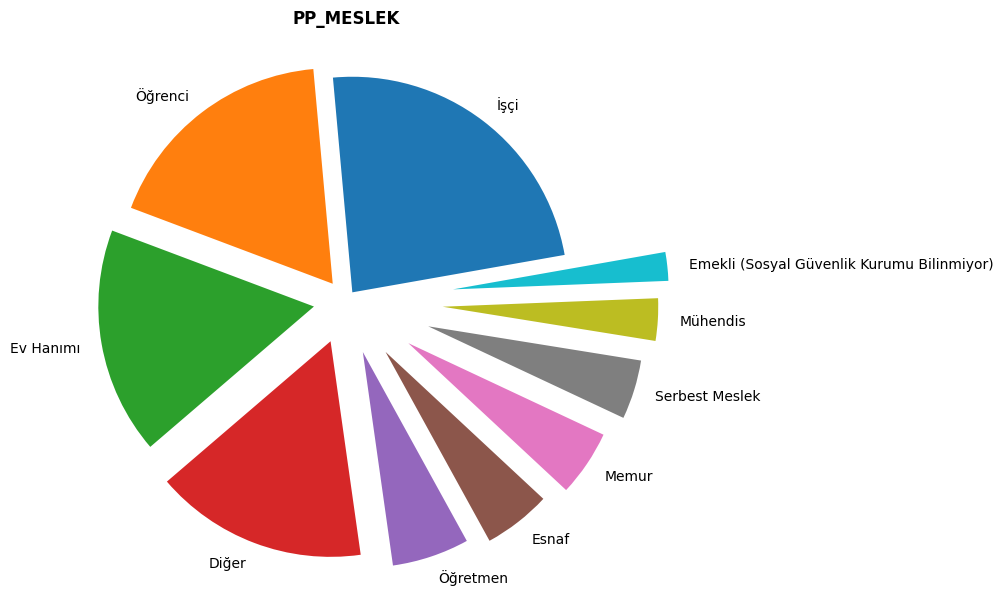

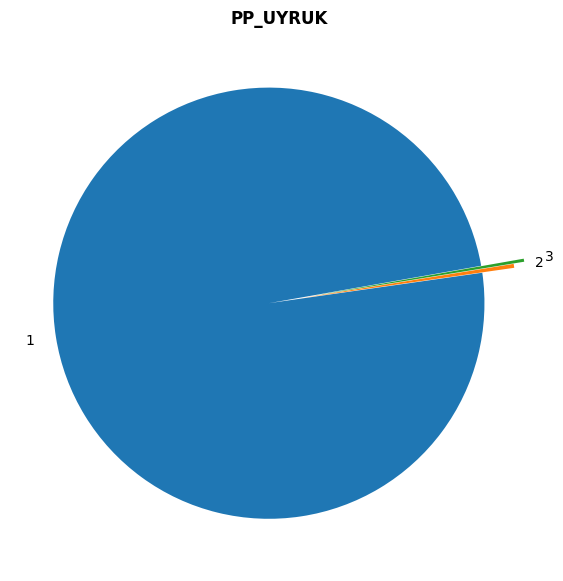

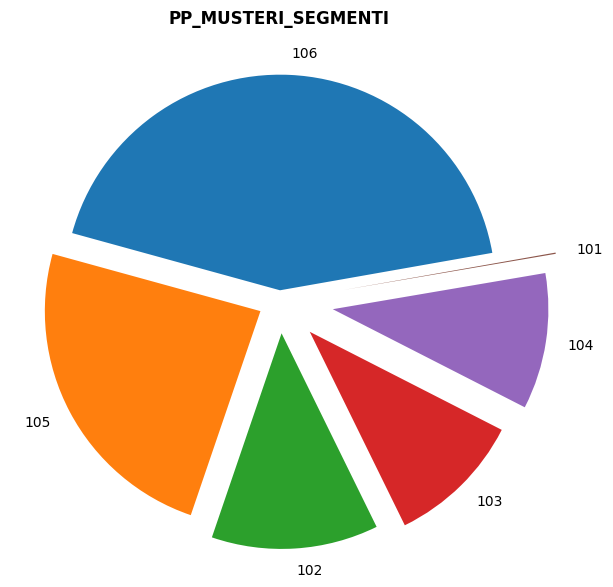

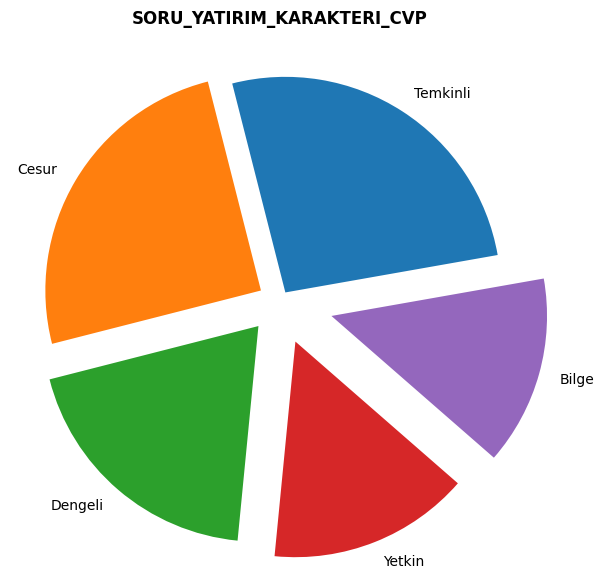

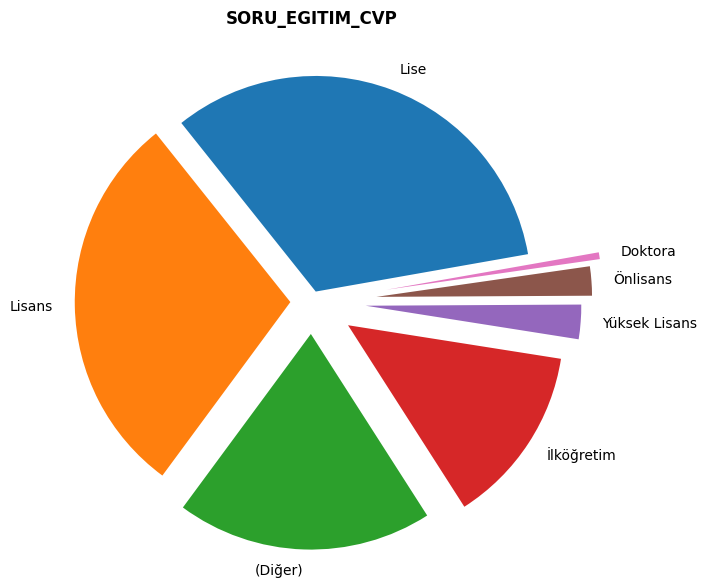

In [8]:
cat_cols = [
    'PP_CINSIYET',
    'PP_MESLEK',
    'PP_UYRUK',
    'PP_MUSTERI_SEGMENTI',
    'SORU_YATIRIM_KARAKTERI_CVP',
    'SORU_EGITIM_CVP'
]

def plot_top_cats(inp_df):
    top_n = 10

    for i, column in enumerate(cat_cols):
        fig, axs = plt.subplots(1, 1, figsize=(10,7))

        value_counts = inp_df[column].value_counts().nlargest(top_n)

        axs.pie(value_counts.values, labels=value_counts.index, startangle=10, explode=np.arange(0.05, 0.05 * (len(value_counts))+0.01, 0.05))

        plt.title(column, fontweight='bold')
        plt.show()
        
plot_top_cats(all_df)

#### Kategorik değerlerin ilgili labelda görünme oranları
Kategorik featureların çoğunun önemli bir ayrıştıcı olduğu görülmektedir. 

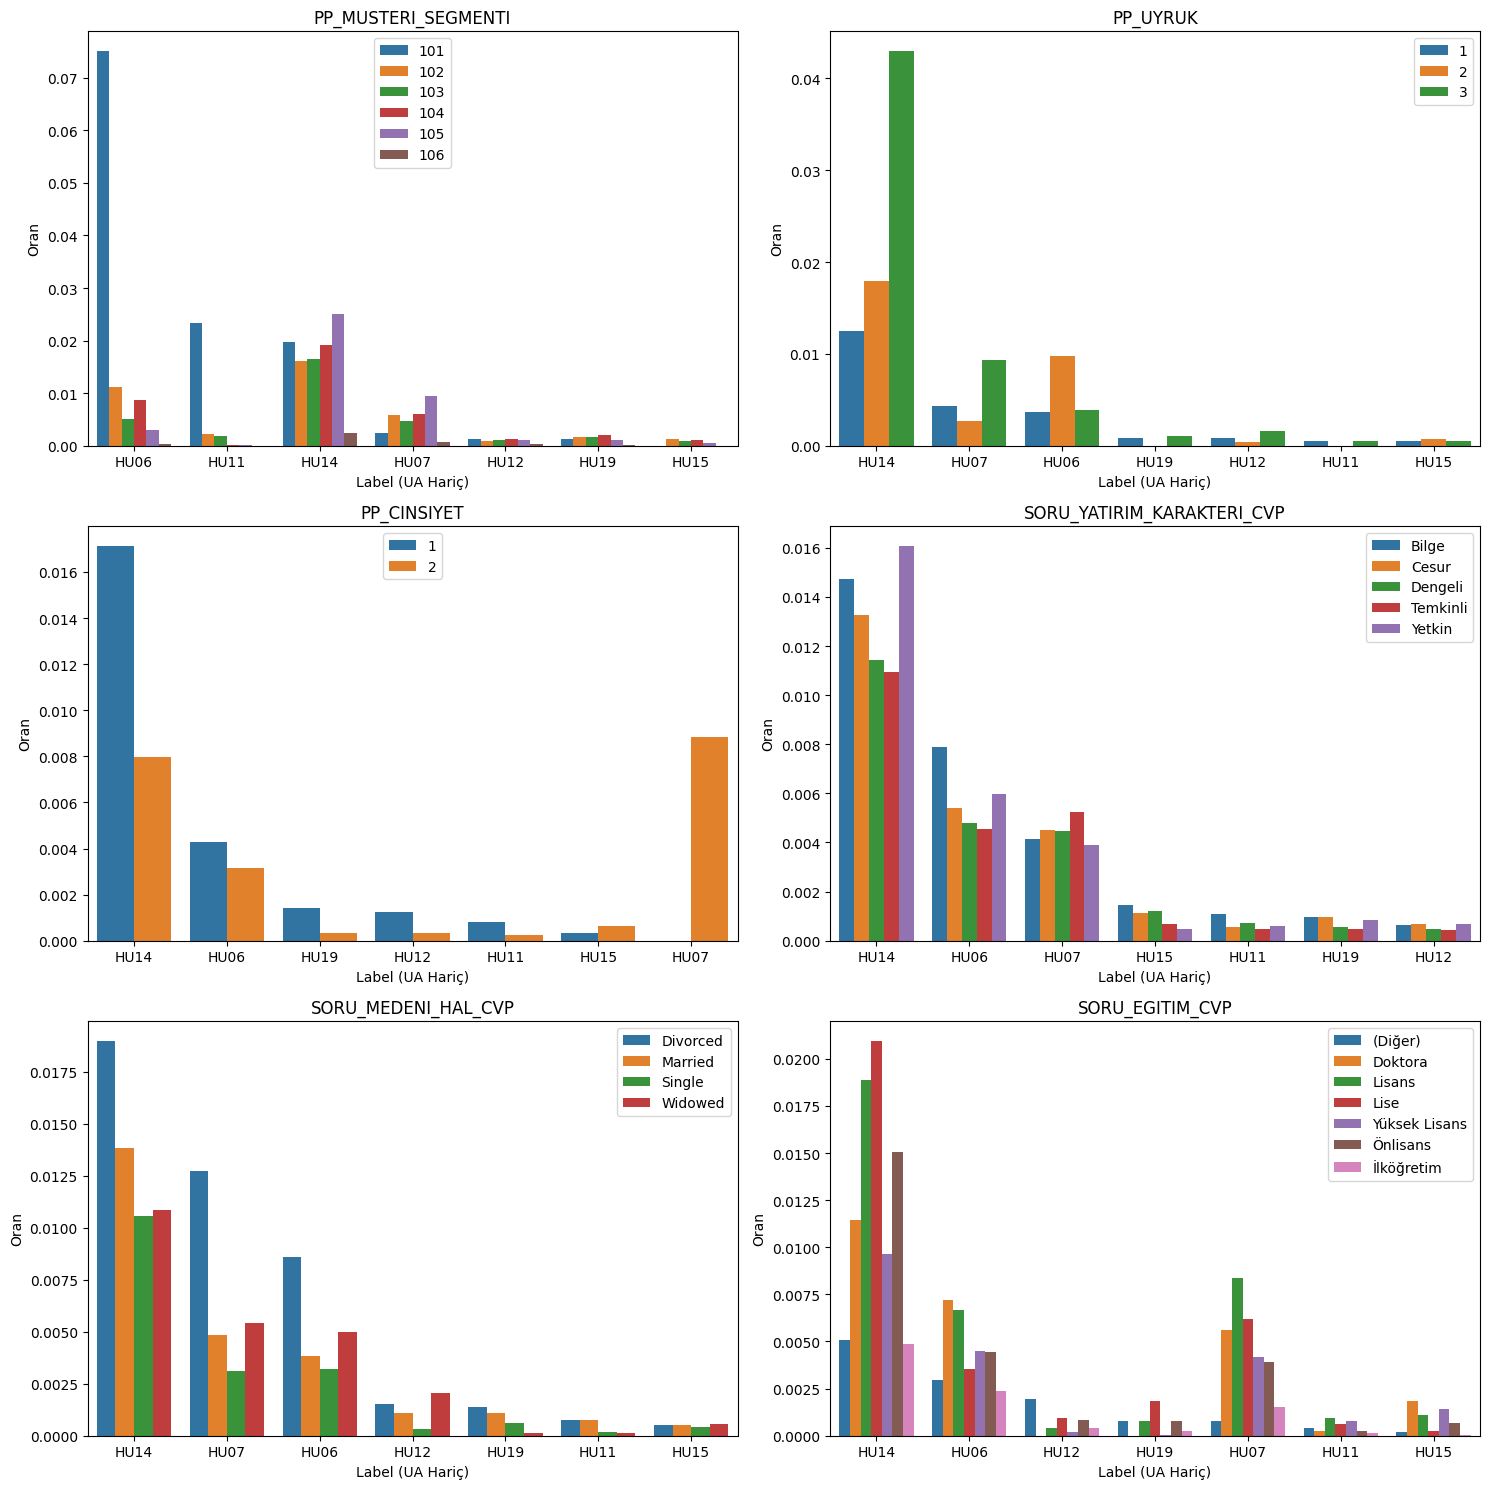

In [9]:
categorical_features = ["PP_MUSTERI_SEGMENTI","PP_UYRUK","PP_CINSIYET","SORU_YATIRIM_KARAKTERI_CVP","SORU_MEDENI_HAL_CVP","SORU_EGITIM_CVP"]
fig, axes = plt.subplots(nrows = len(categorical_features)//2,
                         ncols = 2)
axes = axes.flatten()
fig.set_size_inches(15, 15)

for ax, col in zip(axes, categorical_features):

    segment_label_df= train_df.groupby([col])['LABEL'].value_counts(normalize=True).reset_index()
    segment_label_df = segment_label_df[segment_label_df['LABEL'] != 'UA']
    
    #fig, ax = plt.subplots(1, figsize=(10,7))
    sns.barplot(x=segment_label_df['LABEL'],
                y=segment_label_df['proportion'],
                hue=segment_label_df[col],
                ax=ax)
    
    ax.set_title(f"{col}")
    ax.set_xlabel("Label (UA Hariç)")
    ax.set_ylabel("Oran")
    ax.legend()
    
plt.tight_layout()
plt.show()

#### Sayısal değerler arası korelasyon
Beklendiği gibi *ODEME_TUTAR* ve *VADE_TUTAR* featurelarının birbiriyle ve kendi içindeki yüksek korelasyonu dikkat çekmektedir. *PP_MUSTERI_SEGMENTI*'indeki ordinal ters ilişki de *ODEME* ve *VADE* korelasyonuna yansımaktadır.

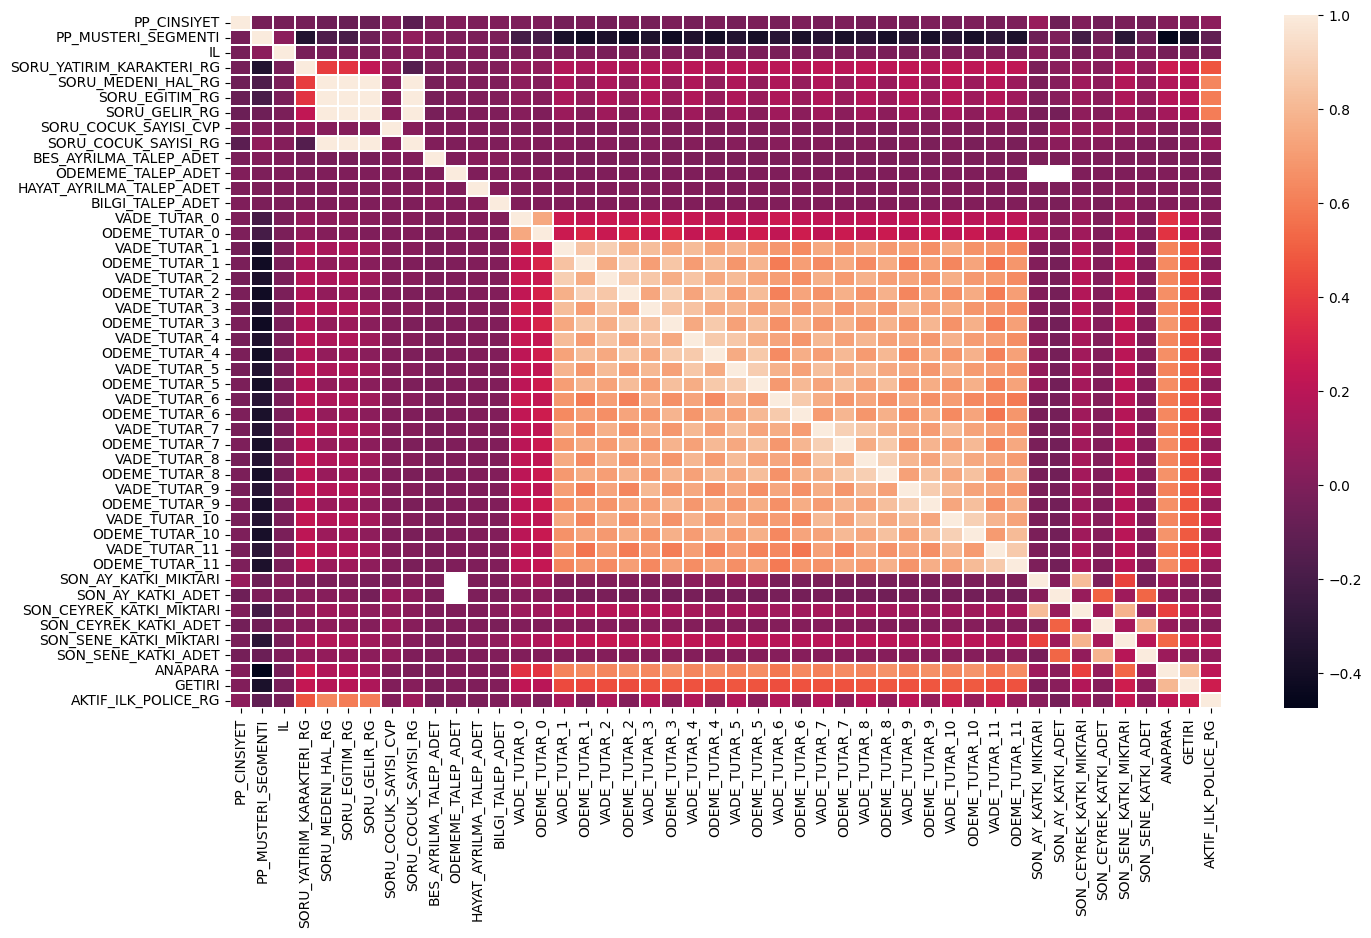

In [10]:
corr_drop_list = ([col for col in train_df.columns if 'BU' in col] +
                  [col for col in train_df.columns if 'HU' in col] +
                  ['PP_YAS','PP_UYRUK']
                 )
corr = train_df.select_dtypes(include=['float','int']).drop(corr_drop_list,axis=1).corr()
plt.figure(figsize=(16,9))
ax = sns.heatmap(corr, linewidths=.1)
plt.yticks(rotation=0)
plt.show()

### 6. Verinin Önişlenmesi

- Gelir bilgisinin numerik olarak standardize edilmesi
- Yaş üzerinde quantile dönüşüm uygulanması
- Gelir bilgisindeki uç derğerlerin filtrelenmesi

In [11]:
def preprocess_fn(inp_df):
    inp_df["SORU_GELIR_CVP"] = inp_df["SORU_GELIR_CVP"].str.replace(",", ".").astype(float)
    
    YAS_bins = [
        -np.inf,
        100,
        200.0,
        300.0,
        400.0,
        500.0,
        600.0,
        700.0,
        800.0,
        900.0,
        1000.0,
        np.inf,
    ]
    
    inp_df['PP_YAS_qcut'] = pd.cut(inp_df['PP_YAS'], YAS_bins).cat.codes.astype(str).fillna("UNK")
    
    inp_df.loc[inp_df['SORU_GELIR_CVP'] <= 100, 'SORU_GELIR_CVP'] = np.nan
    inp_df.loc[inp_df['SORU_GELIR_CVP'] >= 500000, 'SORU_GELIR_CVP'] = np.nan

    return inp_df

In [12]:
all_df = preprocess_fn(all_df)

### 7. Feature Engineering

Veride her müşteri yalnızca bir kere göründüğü için feature engineering metotlarımız satır bazında çalışmaktadır. Verilen bütün bilgiler ışığında anlamlı yeni istatistikler türetmeyi denedik.

#### Şehir Bilgileri

In [13]:
all_df = all_df.merge(city_df[["IL", "latitude", "longitude"]], how="left", on="IL")

#### USD Bilgileri
Beyan edilen gelirlerin beyan dönemine ait kur üzerinden karşılıklarının hesaplanması. Deneylerimizde stabil olmayan sonuçlar ürettiği için kullanmamayı seçtik.

In [14]:
if CFG.USE_USD:
    flag_to_date = {
        'MAYIS':'2023-05-01',
        'HAZIRAN':'2023-06-01',
        'TEMMUZ':'2023-07-01',
        'AGUSTOS':'2023-08-01',
        'EYLUL':'2023-09-01',
        'EKIM':'2023-10-01',
        'KASIM':'2023-11-01',
        'ARALIK':'2023-12-01'
    }
    
    all_df['flag_date'] = all_df['FLAG'].map(flag_to_date)
    all_df['flag_date'] = pd.to_datetime(all_df['flag_date'])
    
    def month_offset(start_date, offset):
        rg_date = np.nan
        try:
            rg_date = start_date - pd.DateOffset(months=offset)
        except:
            pass
        return rg_date
    
    rg_cols = ["SORU_GELIR_RG"]
    
    for rg_col in tqdm(rg_cols):
        all_df[f'{rg_col}_date'] = all_df['flag_date'] - all_df[rg_col].astype('timedelta64[M]')
        all_df[f'{rg_col}_date'] = (all_df[f'{rg_col}_date'].dt.floor('d') + 
                                   pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1))
        
    for rg_col in tqdm(rg_cols):
        all_df = all_df.merge(usd_df.rename(columns={'dolar_tl':f'{rg_col}_dolar'}),
                              how='left',
                              left_on=f'{rg_col}_date',
                              right_on='date')
        
        
    all_df = all_df.drop(['flag_date']+[col for col in all_df.columns if "RG_date" in col],axis=1)
    
    all_df["SORU_GELIR_CVP_in_usd"] = all_df["SORU_GELIR_CVP"] / all_df["SORU_GELIR_RG_dolar"]
    all_df["SORU_GELIR_CVP_in_usd12"] = all_df["SORU_GELIR_CVP_in_usd"] * 12
    all_df["SORU_GELIR_CVP12"] = all_df["SORU_GELIR_CVP"] * 12

#### Müşteri Bazlı Sigorta & Emeklilik Tipi İstatistikleri
Her müşteri için sahip oldukları sigorta ve emeklilik ürünlerinin tipleri üzerinden toplam ürün sayılarını hesaplar.

In [15]:
def get_excel_features(inp_df, excel_df):
    buhudf = inp_df[["MUSTERI_ID"] + [col for col in inp_df if "HU" in col] + [col for col in inp_df if "BU" in col]]

    table = buhudf.melt(id_vars=["MUSTERI_ID"], 
                        var_name="InsuranceType", 
                        value_name="Value")

    table2 = table.merge(excel_df, how="left", on="InsuranceType")    
    
    group_dfs = []

    for gpcol_i, gpcol in enumerate(tqdm(["InsuranceGroupType",
                                          "InsuranceHasCredit",
                                          "InsuranceGuarantee",
                                          "InsuranceSaveType",
                                          "InsuranceTime",
                                          "InsuranceRenewFunc",
                                          "InsuranceAgeReq"])):

        groupcols = [gpcol]

        group_df = table2.groupby(["MUSTERI_ID"] + groupcols)["Value"].sum().unstack(level=[1])
        group_df.columns = ["groupby(" + "_".join(groupcols) + ")_" + col for col in group_df.columns]
        group_df = group_df.reset_index().fillna(0.)

        if gpcol_i>0:
            group_df = group_df.drop(columns=["MUSTERI_ID"])

        group_dfs.append(group_df)
        
    group_dfs = pd.concat(group_dfs, axis=1)  
    
    inp_df = inp_df.merge(group_dfs, how="left", on="MUSTERI_ID")
    
    return inp_df

In [16]:
all_df = get_excel_features(all_df, urun_ozellik_df)

  0%|          | 0/7 [00:00<?, ?it/s]

#### Anket Soruları Cevap Süre İstatistikleri
Anket tarih ikilileri arasındaki süre farkını hesaplar.

In [17]:
def rg_features(inp_df):

    rg_cols = [col for col in inp_df.columns if "RG" in col]
    rg_combs = list(combinations(rg_cols, 2))

    for rg_comb in rg_combs:
        inp_df[f"{rg_comb[0]}_diff_{rg_comb[1]}"] = inp_df[rg_comb[0]] - inp_df[rg_comb[1]]
        
    return inp_df

all_df = rg_features(all_df)

#### Katkı İstatistikleri
Son ay-çeyrek-sene katkı miktarı ve adetleri üzerinden istatistikler çıkarır.

In [18]:
def son_x_katki_features(inp_df):

    col_prefix_names = ["AY", "CEYREK", "SENE"]

    for i in range(len(col_prefix_names)):

        inp_df[f"SON_{col_prefix_names[i]}_katki_per_adet"] = (inp_df[f"SON_{col_prefix_names[i]}_KATKI_MIKTARI"] / inp_df[f"SON_{col_prefix_names[i]}_KATKI_ADET"])
        
        for j in range(i, len(col_prefix_names)):    
            for k in ["_KATKI_MIKTARI", "_KATKI_ADET"]:
                col1 = f"SON_{col_prefix_names[i]}{k}" 
                col2 = f"SON_{col_prefix_names[j]}{k}" 

                inp_df[f"{col1}_ratio_{col2}"] = (inp_df[col1] / inp_df[col2])
                inp_df[f"{col1}_diff_{col2}"] = (inp_df[col1] - inp_df[col2])
    
    return inp_df

all_df = son_x_katki_features(all_df)

#### Ödeme & Vade İstatistikleri
Ödeme ve vade tutarları üzerinden mukayeseler ve istatistikler türetir.

In [19]:
def odeme_vade_features(inp_df):
    
    for i in range(0,12):
        inp_df[f'ODEME_VADE_{i}_diff'] = inp_df[f"ODEME_TUTAR_{i}"] - inp_df[f"VADE_TUTAR_{i}"]
        
    for i in [3,6,9,12]:
        inp_df[f'IS_ODEME_TUTAR_ZERO_{i}'] = sum([(inp_df[f'ODEME_TUTAR_{k}'] == 0).astype(int) for k in range(i)])
        
    inp_df["TOTAL_ODEME_12mo"] = inp_df[[col for col in inp_df if "ODEME_TUTAR" in col]].sum(axis=1)
    inp_df["TOTAL_VADE_12mo"] = inp_df[[col for col in inp_df if "VADE_TUTAR" in col]].sum(axis=1)

    inp_df["TOTAL_ODEME_VADE_diff_12mo"] = inp_df["TOTAL_ODEME_12mo"] - inp_df["TOTAL_VADE_12mo"]
    
    return inp_df

all_df = odeme_vade_features(all_df)

#### Anapara & Getiri
Anapara ve getiri mukayesesine dayalı istatistikler türetir.

In [20]:
def anapara_getiri_features(inp_df):
    inp_df["ANAPARA_GETIRI_diff"] = inp_df["ANAPARA"] - inp_df["GETIRI"]
    inp_df["GETIRI_ANAPARA_ratio"] = inp_df["GETIRI"] / inp_df["ANAPARA"]
    
    for ratiocol in ["GETIRI", "ANAPARA"]:
        inp_df[f"{ratiocol}_TOTAL_ODEME_12mo_diff"] = inp_df[ratiocol] - inp_df["TOTAL_ODEME_12mo"]
        inp_df[f"TOTAL_ODEME_12mo_{ratiocol}_ratio"] = inp_df["TOTAL_ODEME_12mo"] / inp_df[ratiocol]   

        inp_df[f"{ratiocol}_TOTAL_VADE_12mo_diff"] = inp_df[ratiocol] - inp_df["TOTAL_VADE_12mo"]
        inp_df[f"TOTAL_VADE_12mo_{ratiocol}_ratio"] = inp_df["TOTAL_VADE_12mo"] / inp_df[ratiocol]
    
    return inp_df

all_df = anapara_getiri_features(all_df)

#### Hayat Sigortası & BES Ürünleri
Müşterilerin toplam hayat sigortası ve BES ürünü adetlerini hesaplar.

In [21]:
def buhu_features(inp_df):
    inp_df['BU_ALL'] = inp_df[[col for col in inp_df if "BU" in col]].sum(axis=1)
    inp_df['HU_ALL'] = inp_df[[col for col in inp_df if "HU" in col]].sum(axis=1)
    inp_df['BU_HU_ALL'] = inp_df[[col for col in inp_df if "HU" in col]+[col for col in inp_df if "BU" in col]].sum(axis=1)
    return inp_df

all_df = buhu_features(all_df)

#### Müşteri Gruplarına Göre Gelir Ortalaması

In [22]:
customer_segment_cols = ['PP_CINSIYET','PP_YAS_qcut','PP_MESLEK','SORU_MEDENI_HAL_CVP','SORU_EGITIM_CVP','PP_UYRUK']
gelir_adj = all_df[all_df['SORU_GELIR_RG'] <= 10].groupby(customer_segment_cols)['SORU_GELIR_CVP'].mean().rename('SORU_GELIR_CVP_ADJ').reset_index()
all_df = all_df.merge(gelir_adj,how='left', on=customer_segment_cols)

### 8. Modelleme

In [23]:
cat_features = ['PP_CINSIYET',
                'PP_MESLEK',
                'PP_MUSTERI_SEGMENTI',
                'PP_UYRUK',
                'IL',
                'SORU_YATIRIM_KARAKTERI_CVP',
                'SORU_MEDENI_HAL_CVP',
                'SORU_EGITIM_CVP',
               ]
drop_cols = ['FLAG','MUSTERI_ID','PP_YAS_qcut']
target = 'target_enc'

In [24]:
train_df = all_df[all_df.data=='train'].drop('data',axis=1).reset_index(drop=True)
test_df = all_df[all_df.data=='test'].drop('data',axis=1).reset_index(drop=True)

train_df['target_enc'] = train_df.LABEL.map(CFG.TARGET_DICT).astype(int)

In [25]:
X = train_df.drop(drop_cols + ['LABEL',target], axis=1)
y = train_df[target]
X_test = test_df.drop(drop_cols + ['LABEL'], axis=1)

In [26]:
for cat_feat in cat_features:
    X[cat_feat] = X[cat_feat].fillna('UNKNOWN').astype(str).astype('category')
    X_test[cat_feat] = X_test[cat_feat].fillna('UNKNOWN').astype(str).astype('category') 

#### Cross-Validation Şeması

In [27]:
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1, n_repeats=2)
cv_splits = list(cv.split(X, y, groups=train_df["FLAG"]))

#### Model Parametreleri

In [28]:
params = dict(
    allow_writing_files=False,
    cat_features=cat_features,
    iterations=1300,
    use_best_model=False,
    learning_rate=0.1,
    random_state=2,
    depth=6,
    border_count=254,
    l2_leaf_reg=3,
    grow_policy="Lossguide",
    bootstrap_type="Bernoulli",
    min_data_in_leaf=1,
    subsample=0.8,
    objective="MultiClassOneVsAll",
    eval_metric="TotalF1:average=Macro;use_weights=False",
    task_type='GPU',
    devices="0:1",
)

#### Eğitim-Validasyon-Tahmin
GPU eğitimi deterministik olmadığı ve uzun sürdüğü için bu kod yarışma submissionunu üreten modelleri load etmektedir. Eğitimi de baştan kullanmak isterseniz kerneli GPU moduna alıp TRAIN parametresini True'ya almalısınız.

In [29]:
f1_errs = []
models = []
val_preds = []
test_preds = []
test_pred_probas = []
f_importances = []

oof_preds = np.zeros_like(y,dtype='int')

for fold_i, (train_idx, val_idx) in enumerate(tqdm(cv_splits)):

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    print(X_train.shape,X_val.shape)
    
    model = CatBoostClassifier(
        **params,
        auto_class_weights="SqrtBalanced"
    )
    
    if CFG.TRAIN:
        model.fit(X_train, y_train,eval_set=(X_val, y_val),verbose=200)
        model.save_model(f"model_{fold_i}.cbm", format="cbm")
    else:
        model = model.load_model(f"{CFG.LOCAL_PATH}/model_{fold_i}.cbm")
        
    preds = model.predict(X_val)

    test_pred = model.predict(X_test)
    test_pred_proba = model.predict_proba(X_test)
    test_pred_probas.append(test_pred_proba)
    test_preds.append(test_pred)
    f1_err = f1_score(y_val, preds, average=None)
    f1_err = sum(f1_err * CFG.WEIGHT)
    print(f"Fold {fold_i} Score:", f1_err)
    f1_errs.append(f1_err)
    models.append(model)
    f_importances.append(model.get_feature_importance())
    oof_preds[val_idx] = preds.reshape(1,-1)[0]
    print("-----")
    
print(f"Mean F1:{np.round(np.mean(f1_errs),4)}\nF1 Std:{np.round(np.std(f1_errs),4)}")

oof_f1_err = f1_score(y, oof_preds, average=None)
oof_f1_err = sum(oof_f1_err * CFG.WEIGHT)

print(f"OOF Weighted F1 of Last CV Repeat: {oof_f1_err}")

  0%|          | 0/20 [00:00<?, ?it/s]

(767447, 199) (85272, 199)
Fold 0 Score: 0.3040344565284269
-----
(767447, 199) (85272, 199)
Fold 1 Score: 0.2533740819076731
-----
(767447, 199) (85272, 199)
Fold 2 Score: 0.29193413196196866
-----
(767447, 199) (85272, 199)
Fold 3 Score: 0.24384395253912305
-----
(767447, 199) (85272, 199)
Fold 4 Score: 0.2716106556157617
-----
(767447, 199) (85272, 199)
Fold 5 Score: 0.27920968222112047
-----
(767447, 199) (85272, 199)
Fold 6 Score: 0.26225430547695466
-----
(767447, 199) (85272, 199)
Fold 7 Score: 0.2427284772267372
-----
(767447, 199) (85272, 199)
Fold 8 Score: 0.2717832585281064
-----
(767448, 199) (85271, 199)
Fold 9 Score: 0.2742819706729573
-----
(767447, 199) (85272, 199)
Fold 10 Score: 0.261390209250422
-----
(767447, 199) (85272, 199)
Fold 11 Score: 0.2819779487973337
-----
(767447, 199) (85272, 199)
Fold 12 Score: 0.22829642308067674
-----
(767447, 199) (85272, 199)
Fold 13 Score: 0.2822699166293554
-----
(767447, 199) (85272, 199)
Fold 14 Score: 0.30550575595853996
-----


### 10. Feature Importance

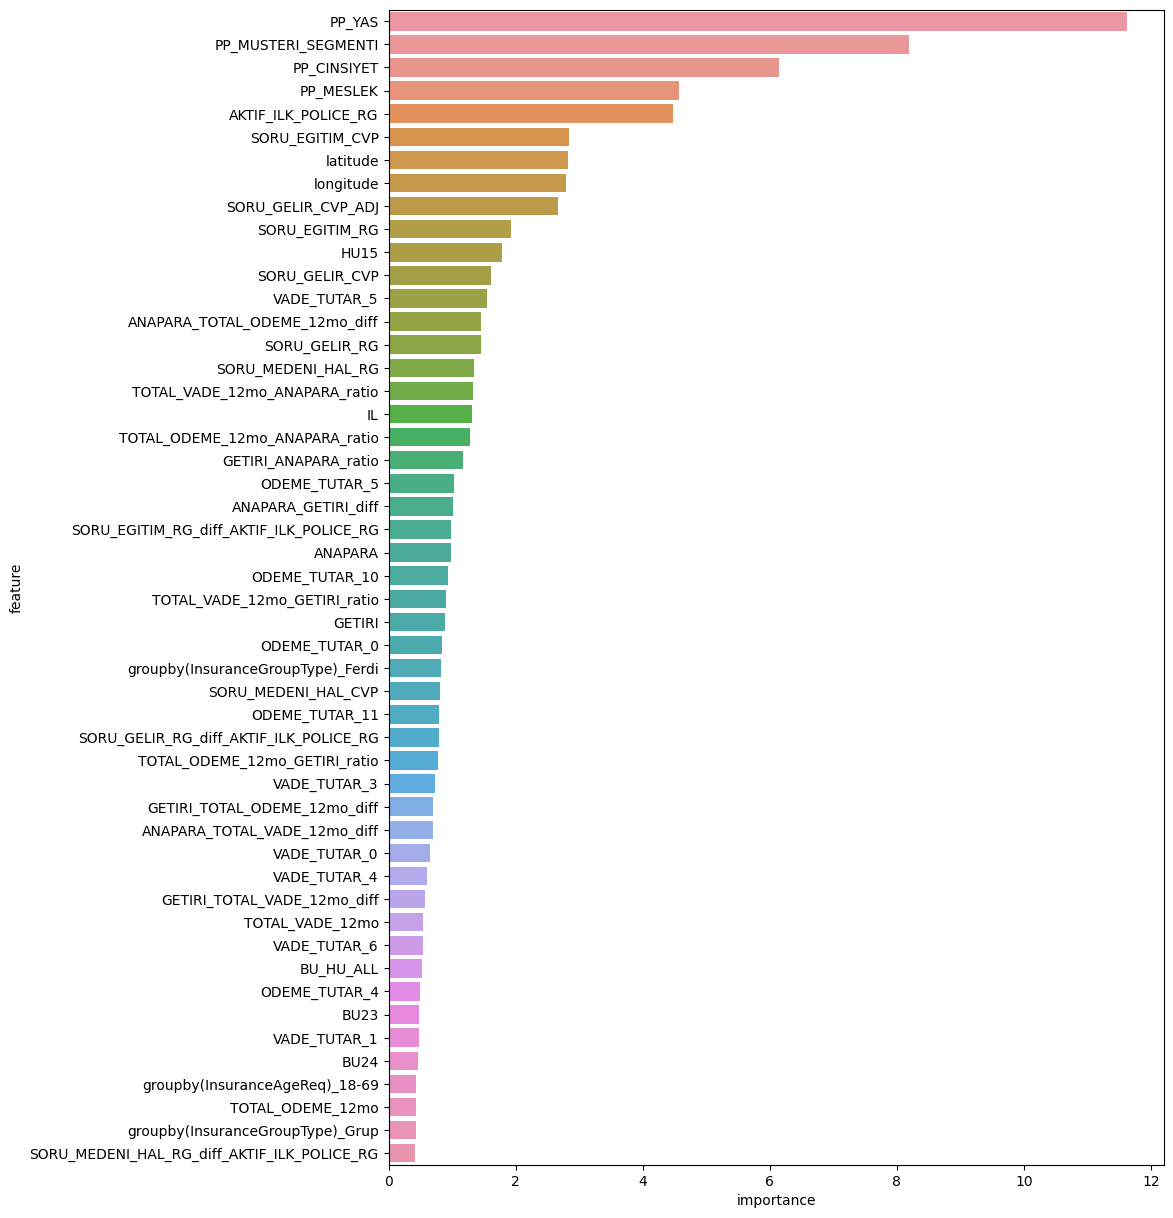

In [30]:
f_imp = pd.DataFrame([model.feature_names_, np.mean(f_importances,axis=0)]).T
f_imp.columns = ['feature','importance']
f_imp = f_imp.sort_values('importance',ascending=False)

fig, ax = plt.subplots(1, figsize=(10, 15))
sns.barplot(x=f_imp['importance'].head(50),
            y=f_imp['feature'].head(50),
            orient='h',
            ax=ax)
plt.show()

### 10. Tahminlerin Üretilmesi
Final tahminler CV modellerinin olasılık çıkışlarının ortalamasına göre üretildi.

In [31]:
ss['LABEL'] = [CFG.PRODUCT[lblkey] for lblkey in np.mean(test_pred_probas, axis=0).argmax(axis=1)]

In [32]:
ss.to_csv('submission.csv', index=False)

#### Tahminlerin Dağılımı

In [33]:
ss['LABEL'].value_counts(normalize=True)

LABEL
UA      0.957159
HU14    0.023984
HU07    0.012089
HU06    0.003353
HU19    0.001733
HU12    0.000797
HU11    0.000649
HU15    0.000235
Name: proportion, dtype: float64